# Access Computation

This tutorial demonstrates how to compute access.

## Setup

In [2]:
import pandas as pd

import plotly.graph_objs as go

from ostk.mathematics.object import RealInterval

from ostk.physics import Environment
from ostk.physics.unit import Length
from ostk.physics.unit import Angle
from ostk.physics.time import Scale
from ostk.physics.time import Instant
from ostk.physics.time import Duration
from ostk.physics.time import Interval
from ostk.physics.time import DateTime
from ostk.physics.time import Time
from ostk.physics.coordinate.spherical import LLA
from ostk.physics.coordinate import Position
from ostk.physics.coordinate import Frame

from ostk.astrodynamics import Trajectory
from ostk.astrodynamics.trajectory import Orbit
from ostk.astrodynamics.trajectory.orbit.model import Kepler
from ostk.astrodynamics.trajectory.orbit.model.kepler import COE
from ostk.astrodynamics.trajectory.orbit.model import SGP4
from ostk.astrodynamics.trajectory.orbit.model.sgp4 import TLE
from ostk.astrodynamics.access import Generator as AccessGenerator
from ostk.astrodynamics.utilities import compute_trajectory_geometry
from ostk.astrodynamics.utilities import compute_time_lla_aer_state

---

## Access

An access represents an object-to-object visibility period.

In this example, let's compute accesses between a fixed position on the ground and a satellite in LEO.

## Environment

Let's setup an environment (which describes where planets are, etc...):

In [3]:
environment = Environment.default()
earth = environment.access_celestial_object_with_name("Earth")

### Origin

Let's define a fixed ground position, using its geographic coordinates:

In [4]:
latitude = Angle.degrees(50.0)
longitude = Angle.degrees(20.0)
altitude = Length.meters(30.0)

In [5]:
from_lla = LLA(latitude, longitude, altitude)

In [6]:
from_position = Position.meters(
    from_lla.to_cartesian(earth.get_equatorial_radius(), earth.get_flattening()),
    Frame.ITRF(),
)

And derive a trajectory, fixed at that position:

In [7]:
from_trajectory = Trajectory.position(from_position)

### Target

Let's consider a satellite in **Low-Earth Orbit**.

In [8]:
earth = environment.access_celestial_object_with_name("Earth")

We can define its orbit with **Classical Orbital Elements**:

In [9]:
a = earth.get_equatorial_radius() + Length.kilometers(500.0)
e = 0.000
i = Angle.degrees(97.8893)
raan = Angle.degrees(100.372)
aop = Angle.degrees(0.0)
nu = Angle.degrees(0.0201851)

coe = COE(a, e, i, raan, aop, nu)

... and by using a **Keplerian** orbital model:

In [10]:
epoch = Instant.date_time(DateTime(2018, 1, 1, 0, 0, 0), Scale.UTC)

keplerian_model = Kepler(coe, epoch, earth, Kepler.PerturbationType.J2)

Or with a **Two-Line Element** (TLE) set:

In [11]:
tle = TLE(
    "ISS (ZARYA)",
    "1 25544U 98067A   18268.86272795  .00002184  00000-0  40781-4 0  9990",
    "2 25544  51.6405 237.0010 0003980 205.4375 242.3358 15.53733046134172",
)

... along with its associated **SGP4** orbital model:

In [12]:
sgp4_model = SGP4(tle)

Below, we select which orbital model to use:

In [13]:
orbital_model = keplerian_model
# orbital_model = sgp4_model

We then obtain the satellite orbit (which is a **Trajectory** object):

In [14]:
satellite_orbit = Orbit(orbital_model, earth)

Alternatively, the **Orbit** class can provide some useful shortcuts (for usual orbit types):

In [15]:
epoch = Instant.date_time(DateTime(2018, 1, 1, 0, 0, 0), Scale.UTC)

satellite_orbit = Orbit.sun_synchronous(
    epoch, Length.kilometers(500.0), Time(12, 0, 0), earth
)

### Access

Now that the origin and the target trajectories are well defined, we can compute the **Access**.

Let's first define an **analysis interval**:

In [16]:
start_instant = Instant.date_time(DateTime.parse("2018-01-01 00:00:00"), Scale.UTC)
end_instant = Instant.date_time(DateTime.parse("2018-01-10 00:00:00"), Scale.UTC)

interval = Interval.closed(start_instant, end_instant);

Then, using an **Access Generator**, we can compute the accesses within the intervals of interest:

In [17]:
azimuth_range = RealInterval.closed(0.0, 360.0)  # [deg]
elevation_range = RealInterval.closed(20.0, 90.0)  # [deg]
range_range = RealInterval.closed(0.0, 10000e3)  # [m]

# Access generator with Azimuth-Range-Elevation constraints

access_generator = AccessGenerator.aer_ranges(
    azimuth_range, elevation_range, range_range, environment
)

In [18]:
accesses = access_generator.compute_accesses(interval, from_trajectory, satellite_orbit)

And format the output using a dataframe:

In [19]:
accesses_df = pd.DataFrame(
    [
        [
            str(access.get_type()),
            repr(access.get_acquisition_of_signal()),
            repr(access.get_time_of_closest_approach()),
            repr(access.get_loss_of_signal()),
            float(access.get_duration().in_seconds()),
        ]
        for access in accesses
    ],
    columns=["Type", "AOS", "TCA", "LOS", "Duration"],
)

### Output

Print accesses:

In [117]:
accesses_df

,Type,AOS,TCA,LOS,Duration
0,Type.Complete,2018-01-01 11:34:42.068.803.594 [UTC],2018-01-01 11:37:02.531.259.406 [UTC],2018-01-01 11:39:20.963.932.540 [UTC],278.895129
1,Type.Complete,2018-01-01 22:17:04.486.465.786 [UTC],2018-01-01 22:19:29.197.893.877 [UTC],2018-01-01 22:21:56.071.797.954 [UTC],291.585332
2,Type.Complete,2018-01-02 11:15:50.962.671.891 [UTC],2018-01-02 11:18:21.588.871.661 [UTC],2018-01-02 11:20:50.113.754.946 [UTC],299.151083
3,Type.Complete,2018-01-02 21:58:17.197.808.714 [UTC],2018-01-02 22:00:45.574.983.540 [UTC],2018-01-02 22:03:16.059.148.910 [UTC],298.861340
4,Type.Complete,2018-01-03 10:57:11.487.524.290 [UTC],2018-01-03 10:59:37.850.534.878 [UTC],2018-01-03 11:02:02.036.875.988 [UTC],290.549352
5,Type.Complete,2018-01-03 21:39:47.134.122.825 [UTC],2018-01-03 21:42:04.761.556.620 [UTC],2018-01-03 21:44:24.416.835.048 [UTC],277.282712
6,Type.Complete,2018-01-04 10:38:46.114.810.487 [UTC],2018-01-04 10:40:51.272.953.198 [UTC],2018-01-04 10:42:54.213.740.990 [UTC],248.098931
7,Type.Complete,2018-01-04 12:13:44.164.602.232 [UTC],2018-01-04 12:14:29.283.796.794 [UTC],2018-01-04 12:15:12.483.817.521 [UTC],88.319215
8,Type.Complete,2018-01-04 21:21:37.263.730.846 [UTC],2018-01-04 21:23:26.748.795.776 [UTC],2018-01-04 21:25:18.172.380.735 [UTC],220.908650
9,Type.Complete,2018-01-04 22:56:06.153.258.257 [UTC],2018-01-04 22:57:18.443.397.319 [UTC],2018-01-04 22:58:32.957.423.180 [UTC],146.804165


Let's calculate the geographic coordinate of the satellite, during access:

In [118]:
def compute_access_geometry(access):
    return [
        compute_time_lla_aer_state(state, from_position, environment)
        for state in satellite_orbit.get_states_at(
            access.get_interval().generate_grid(Duration.seconds(1.0))
        )
    ]

In [119]:
satellite_orbit_geometry_df = pd.DataFrame(
    compute_trajectory_geometry(satellite_orbit, interval),
    columns=["Latitude", "Longitude", "Altitude"],
)

In [120]:
satellite_orbit_geometry_df.head()

,Latitude,Longitude,Altitude
0,-0.020152,-0.001105,500000.002625
1,3.772321,-0.734928,500091.839402
2,7.564114,-1.472946,500367.684689
3,11.354544,-2.219521,500822.628803
4,15.142919,-2.979323,501448.578113


In [121]:
access_geometry_dfs = [
    pd.DataFrame(
        compute_access_geometry(access),
        columns=[
            "Time",
            "Latitude",
            "Longitude",
            "Altitude",
            "Azimuth",
            "Elevation",
            "Range",
        ],
    )
    for access in accesses
];

In [122]:
def get_max_elevation(df):
    return df.loc[df["Elevation"].idxmax()]["Elevation"]

And plot the geometries onto a map:

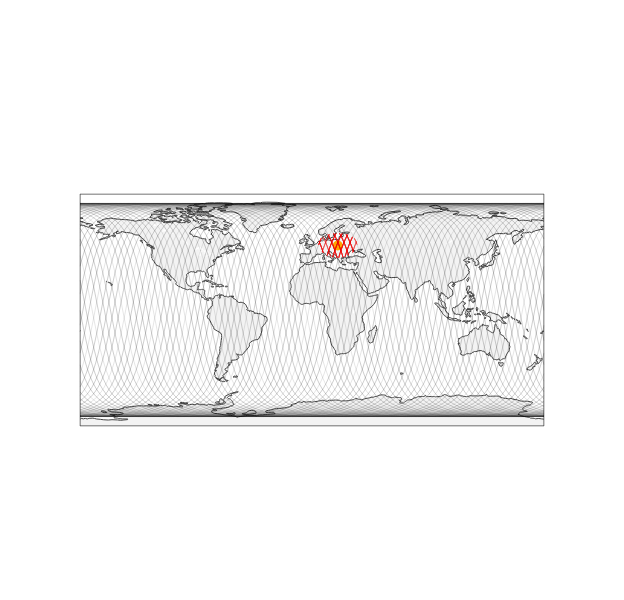

In [123]:
data = []

# Target geometry

data.append(
    dict(
        type="scattergeo",
        lon=[float(longitude.in_degrees())],
        lat=[float(latitude.in_degrees())],
        mode="markers",
        marker=dict(size=10, color="orange"),
    )
)

# Orbit geometry

data.append(
    dict(
        type="scattergeo",
        lon=satellite_orbit_geometry_df["Longitude"],
        lat=satellite_orbit_geometry_df["Latitude"],
        mode="lines",
        line=dict(
            width=1,
            color="rgba(0, 0, 0, 0.1)",
        ),
    )
)

# Access geometry

for access_geometry_df in access_geometry_dfs:
    data.append(
        dict(
            type="scattergeo",
            lon=access_geometry_df["Longitude"],
            lat=access_geometry_df["Latitude"],
            mode="lines",
            line=dict(
                width=1,
                color="red",
            ),
        )
    )

layout = dict(
    title=None,
    showlegend=False,
    width=1200,
    height=600,
    geo=dict(
        showland=True,
        landcolor="rgb(243, 243, 243)",
        countrycolor="rgb(204, 204, 204)",
    ),
)

figure = go.Figure(data=data, layout=layout)

#figure.show("svg")
figure.show()

---